# Zadanie domowe - implementacja algorytmu NSGA-II

Zrealizowali:
<ol>
  <li>Joanna Cicha, 147963</li>
  <li>Maciej Mak, 147511</li>
</ol>

In [36]:
# Import niezbędnych bibliotek
# inline = pozwala wykreślać wykresy biblioteki matplotlib w okienkach jupytera
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

In [37]:
### Klasa Solution
class Solution:
    def __init__(self, x, f, name):
        self.x = x ### zmienne decyzyjne
        self.f = f ### wektor ocen [f1, f2]
        self.front = 0 ## pomocnicza wartość przechowująca numer niezdominowanego frontu
        self.cd = 0.0 ## pomocnicza wartość przechowująca wartość crowding distance
        self.name = name ### pomocnicza nazwa rozwiązania

    def __str__(self):
        return "[" + self.name + " : F = " + str(self.f) + "]"

In [38]:
### TODO należy uzupełnić funkcję obliczającą realizacjię kryteriow w oparciu o informacje w pliku PDF
### wejście = wektor zmiennych decyzyjnych; wyjście = wektor ocen
# Ewluacja rozwiazaąnia w oparciu o zmienne decyzyjne

def evaluate(x):
    x1, x2, x3, x4, x5 = x
    l = 1 + abs(x2 ** 10 - 0.5) + x3 + x4 + x5
    f1 = x1 ** 10 * l
    f2 = (1 - x1 ** 10) * l
    return [f1, f2]

In [39]:
### Procedura tworzy populacje początkowa o zadanym rozmiarze N
def constructInitialPopulation(N):
    P = []
    for i in range(N):
        x = [j for j in range(5)] 
        x[0] = np.random.rand()
        x[1] = np.random.rand()      
        for j in range(2,5): x[j] = np.random.randint(0,2)
        f = evaluate(x) ### ewaluacja rozwiązania
        P.append(Solution(x, f, str(0)+"-"+str(i))) ### dodanie rozwiązania do listy, 
        # nazwa składa się z dwóch członów: numer generacji, 
        # w której rozwiązanie zostało wygenerowane oraz numer rozwiązania w populacji
    return P

P = constructInitialPopulation(10000)
for s in P[:10]: print(s) ### Wypisanie przykładowych rozwiązań (dla testu)

[0-0 : F = [0.04616220019125847, 2.452852556351359]]
[0-1 : F = [2.2939332556085437, 0.20606668333972092]]
[0-2 : F = [8.242338751082243e-07, 2.4999991416936482]]
[0-3 : F = [5.572110224328805e-08, 4.4993324517265245]]
[0-4 : F = [0.00018961206061828228, 1.4998100315084046]]
[0-5 : F = [0.0001065116498099946, 2.4998223888318964]]
[0-6 : F = [0.02844579886427043, 1.4715542011070162]]
[0-7 : F = [0.011519149521716916, 2.4884808498758173]]
[0-8 : F = [0.06983909940640998, 3.430160650462682]]
[0-9 : F = [2.0958766960971322e-07, 2.4999731628671116]]


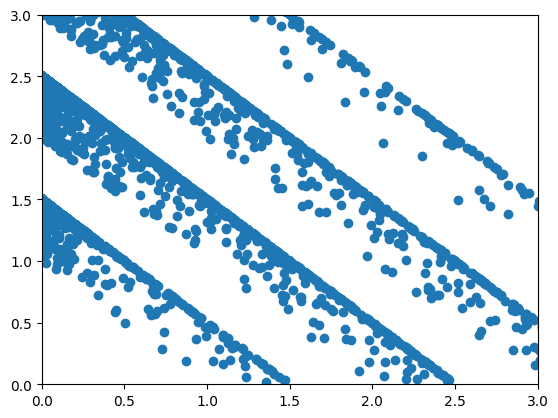

In [40]:
### Poniższa funkcja wykreśla rozwiązania w P wykorzystując wykres punktowy. 
### Przy dużym rozmiarze N można zaobserwowa jak losowo wygenerowane rozwiązania 
### rozkładają się w przestrzeni ocen. Proszę sprawdzić np. dla N=10000. 
### TODO Proszę uzasadnić uzyskany rozkład odwołując się do definicji problemu (funkcji ocen)

def plotPopul(P):
    plt.figure()
    X = [s.f[0] for s in P]
    Y = [s.f[1] for s in P]
    plt.plot(X, Y, ls='', marker='o')
    plt.xlim(0, 3.0);
    plt.ylim(0, 3.0)

plotPopul(P)

In [41]:
### TODO poniższa funkcja winna zwracać listę par indeksów rozwiązań wybranych do reprodukcji.
### Z każdej pary zostanie utworzone jedno rozwiązanie potomne. 
### Selekcja powinna odbywać się w oparciu o turniej o rozmiarze 2
### Wyjście: lista par -> [ [idx11, idx12],...,[idxN1, idxN2] ]
import random

def constructParents(N):
    pairs = []
    for _ in range(N):
        candidates = random.sample(range(N), 2)
        pairs.append([candidates[0], candidates[1]])
    return pairs

print(constructParents(10)) ### TEST

[[2, 5], [0, 9], [4, 2], [4, 0], [8, 7], [2, 5], [7, 2], [3, 8], [8, 3], [2, 5]]


In [42]:
# TODO poniższa funkcja powinna dokonywać krzyżowania dwóch wejściowych wektorów
# zmiennych decyzyjnych. Procedura może zostać zaimplementowana w dowolny sposób
# Sugerowane najprostsze rozwiązanie: "potomek" przy określaniu wartości każdej zmiennej
# przejmuje wartość od losowego rodzica.

def getCrossed(xA, xB):
    return [random.choice([xA[i], xB[i]]) for i in range(len(xA))]


print(getCrossed([0.0, 0.5, 1.0], [1.0, 0.25, 0.75])) ### TEST

[0.0, 0.25, 1.0]


In [43]:
# TODO poniższa funkcja winna "mutować" wejściowy wektor x (operacje powinny być wykonywane)
# na x. Należy w procedurze uwzględnić prawdopodobieństwo zajścia 
# mutacji dla każdej zmiennej decyzyjnej. W przypadku zmiennych binarnych mutacja winna być
# zrealizowana jako dopełnienie zmiennej do 1: nowe x[i] = 1 - x[i]. W przypadku zmiennych ciągłych 
# można wykorzystać mutację gausowską, tzn. dodać do wartości losową liczbę z rozkładu
# normalnego o odchyleniu standardowym podanym na wejściu metody "std"
# Należy tutaj zabezpieczyć procedurę przed potencjalnym przekroczeniu tak zaktualizowanej
# wartości poza dozwolony przedział [0, 1]

def mutate(x, prob, std):
    for i in range(len(x)):
        if random.random() < prob:
            if i < 2: # Ciągłe zmienne
                x[i] += random.gauss(0, std)
                x[i] = min(max(x[i], 0), 1)
            else: # Binarnie zmienne
                x[i] = 1 - x[i]

for std in [0.0, 0.1, 0.2]: ## TEST
    x = [0.0, 0.2, 1.0, 0.0, 0.0]
    mutate(x, 1.0, std)
    print(x)

[0.0, 0.2, 0.0, 1.0, 1.0]
[0, 0.05922245467924114, 0.0, 1.0, 1.0]
[0, 0.4783281168962916, 0.0, 1.0, 1.0]


In [44]:
### Proszę zapoznać się z poniższą metodą
### Generuja ona wektor rozwiązań potomnych w oparciu o wyselekcjonowanych rodziców
### i przyjęte operatory reprodukcji

def constructOffspring(P, parents, gen, std):
    O = []
    prob = 1.0 / 5.0
    for i in range(len(parents)):
        xO = getCrossed(P[parents[i][0]].x, P[parents[i][1]].x)
        mutate(xO, prob, std)
        O.append(Solution(xO, evaluate(xO), str(gen) + "-" + str(i)))
    return O

In [45]:
# Pomocnicza metoda określająca zajście relacji dominacji
def dominates(sj, sk):
    if sj.f[0] < sk.f[0] and sj.f[1] <= sk.f[1]: return True
    if sj.f[0] <= sk.f[0] and sj.f[1] < sk.f[1]: return True
    return False

In [46]:
### TODO Poniższa funkcja winna realizować przydział rozwiązań do frontów niezdominowanych
### Wyjściem powinna być lista list indeksów rozwiązań w P, przydzielonych do odpowiednich frontów.
### Np. wyjście: [[3,4,0],[1,5],[2]] oznacza, że rozwiązania nr 0, 3, 4 w P są w pierszym froncie,
### 1 i 5 w drugim, a rozwiązanie numer 2 w ostatnim.

def getNonDominatedFronts(P):
    fronts = []
    current_front = []
    for i, si in enumerate(P):
        dominated_count = 0
        dominates_set = set()
        for j, sj in enumerate(P):
            if dominates(si, sj):
                dominates_set.add(j)
            elif dominates(sj, si):
                dominated_count += 1
        if dominated_count == 0:
            si.front = 0
            current_front.append(i)
        si.dominates = dominates_set
        si.dominated_count = dominated_count

    fronts.append(current_front)
    current_index = 0
    while current_index < len(fronts):
        next_front = []
        for i in fronts[current_index]:
            si = P[i]
            for j in si.dominates:
                P[j].dominated_count -= 1
                if P[j].dominated_count == 0:
                    P[j].front = current_index + 1
                    next_front.append(j)
        if len(next_front) == 0:
            break
        fronts.append(next_front)
        current_index += 1
    return fronts

In [47]:
### TODO poniższa metoda winna obliczać wartości crowding distance (cd)
# dla rozwiazań w P. UWAGA: cd jest obliczany dla niezdominowanych frontów z osobna;
# obliczając cd dla rozwiązań w jednym froncie "zapominamy" o pozostałych rozwiązaniach.
# Metoda winna zwrócić wektor uzyskanych cd

def getCrowdingDistances(F, P):
    crowding_distances = [0.0] * len(P)
    for front in F:
        if len(front) == 1:  # Jeśli front ma tylko jedno rozwiązanie
            crowding_distances[front[0]] = float("inf")
            continue

        for m in range(2):  # Dla obu kryteriów
            sorted_F = sorted(front, key=lambda x: P[x].f[m])

            crowding_distances[sorted_F[0]] = float("inf")
            crowding_distances[sorted_F[-1]] = float("inf")

            for j in range(1, len(front) - 1):
                crowding_distances[sorted_F[j]] += (P[sorted_F[j + 1]].f[m] - P[sorted_F[j - 1]].f[m])

    return crowding_distances

In [48]:
### Poniższa metoda przydziela rozwiązaniom ich numery niezdominowanych frontów i wartości cd,
# a także sortuje rozwiązania w populacji w oparciu o te wartości. 
# W przypadku, gdy useCD = False, miara cd nie jest uwzględniona przy sortowaniu.
# Przetestowanie metody dla useCD = True i False pozwoli zaobserwować zysk wynikający
# z wykorzystania miary cd.

def applyScoresAndSort(P, useCD = True):
    F = getNonDominatedFronts(P)
    CD = [0 for _ in P]
    if useCD:
        CD = getCrowdingDistances(F, P)

    for s, f in enumerate(F):
         for i in f: 
            P[i].front = s
            P[i].cd = CD[i]
   
    P.sort(key=lambda x: x.cd, reverse=True)
    P.sort(key=lambda x: x.front) # Kryterium sortowania

In [49]:
# TODO Poniższa funkcja winna obliczać pomocnicze statystyki, które pomogą
# uzasadnić wykorzystanie miary cd w obliczeniach.
# Metoda tak winna zwrócić średnią, maksymalną, minimalną wartość 
# cd dla rozwiązań, oraz odchylenie standardowe tych wartości
# w populacji P. Przy obliczaniu statystyk należy pominąć wartości graniczne (nieskończoność),
# uzyskiwane przez wartości graniczne
# Jak należy interpretować te miary?

def getStatsCD(P):
    finite_cd = [s.cd for s in P if s.cd != float("inf")]
    if finite_cd:
        mean_cd = np.mean(finite_cd)
        max_cd = np.max(finite_cd)
        min_cd = np.min(finite_cd)
        std_cd = np.std(finite_cd)
        return mean_cd, max_cd, min_cd, std_cd
    return None, None, None, None


[0-0 : F = [0.00633198241783605, 2.3274029119027273]]
[0-1 : F = [6.345259219193495e-06, 2.4999936547407806]]
[0-2 : F = [0.7397656521292169, 1.7601575051723306]]
[0-3 : F = [8.756712924081827e-10, 4.499999803240103]]
[0-4 : F = [0.0020363303736273546, 3.497963669258932]]
[0-5 : F = [3.4116736174447304e-14, 4.499999999999964]]
[0-6 : F = [0.12342603633431384, 3.225896728276072]]
[0-7 : F = [1.1651197232432413, 1.3138297565255577]]
[0-8 : F = [0.0014897334849146822, 2.4984792024991167]]
[0-9 : F = [0.6068240058057225, 1.6649826786462523]]
[1-0 : F = [0.002036330259873992, 3.4979634738559002]]
[1-1 : F = [4.711828861449044e-05, 2.4999146817952185]]
[1-2 : F = [0.00678309731247367, 2.493216088582567]]
[1-3 : F = [0.12897750483357381, 3.370991431150458]]
[1-4 : F = [0.10569451736941617, 2.394301550196963]]
[1-5 : F = [0.009045222226370312, 3.324689672094193]]
[1-6 : F = [4.864840343966249e-10, 2.49999980362929]]
[1-7 : F = [1.8953742319137383e-14, 2.4999999999999787]]
[1-8 : F = [1.6224279

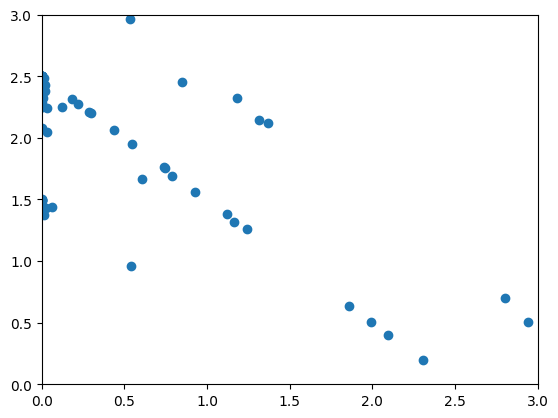

In [50]:
# Generacja populacji początkowej
P = constructInitialPopulation(100)
for s in P[:10]:
    print(s)

plotPopul(P)

# Selekcja rodziców i konstrukcja potomstwa
parents = constructParents(10)
O = constructOffspring(P, parents, 1, 0.1)
for s in O[:10]:
    print(s)

# Sortowanie i ocena rozwiązań
applyScoresAndSort(P, useCD=True)
for s in P[:10]:
    print(s)
stats = getStatsCD(P)
print(f"Mean CD: {stats[0]}, Max CD: {stats[1]}, Min CD: {stats[2]}, Std CD: {stats[3]}")


Poniższe dwie komórki realizują działanie algorytmu NSGA-II, ilustrują skonstruowane rozwiązania na 5 różnych etapach działania algorytmu i ostateczni wypisują uzyskane statystki dla CD. W pierwszej komórce cd nie jest wykorzystane przy sortowaniu, w drugiej jest. Należy zapoznać się z kodem i przetestować działanie dla różnych parametrów (rozmiary populacji, itp). Dla którego wariantu algorytm wykazał się lepszym działaniem? (powinien dla tego, który wykorzystywał miarę cd ;) ) <br>

<b>Dla chętnych: </b> algorytmy ewolucyjne są losowe. Z tego powodu jednokrotne ich uruchomienie nie jest wiarygodne. By uzyskać bardziej wiarygodny wynik, algorytm może zostać uruchomiony np. 20 razy a uzyskane statystyki uśrednione. Dodatkowo można je obliczyć dla każdej generacji (nie tylko w ostatniej) i wykreślić ich zbieżność na wykresie liniowym. Na jednym wykresie można wykreślić wyniki uzyskane przez oba warianty algorytmu - dzięki czemu różnice powinny byc lepiej widoczne. Proszę zauważyć jednak, że statystki dla cd nie są możliwie najlepszą miarą oceny jakości działania algorytmu. Na samym początku, gdy rozwiązania są silnie rozproszone, ich wartości cd powinny być bardzo wysokie, co jest w sprzeczności z założeniem, że "im większe cd tym lepiej". Aby wiarygodniej oceniać takie algorytmy, należy także wykorzystywać miary, które szacują odległość rozwiązań do frontu Pareta. Można zaproponować taką miarę i wykorzystać ją do pokazania "bliskości" populacji do tego frontu. Dopiero jednoczesne zestawienie takiej miary i miary oceniającej rozproszenie rozwiązań umożliwi lepsze porównanie algorytmów. 

(0.0, 0, 0, 0.0)


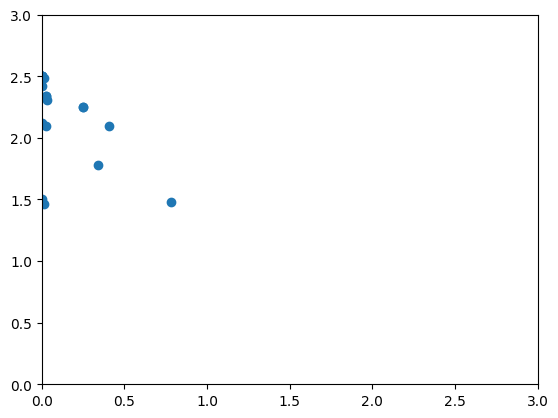

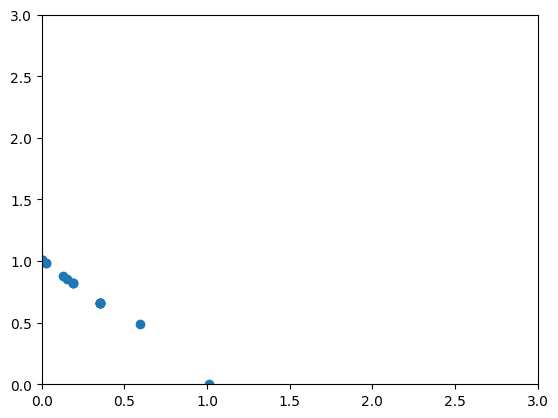

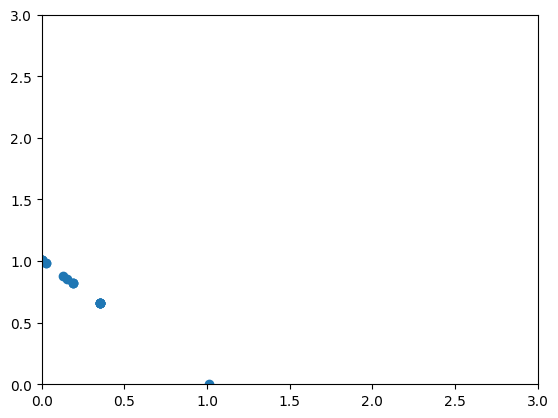

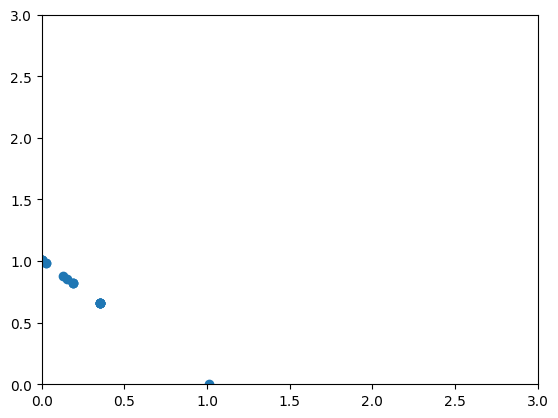

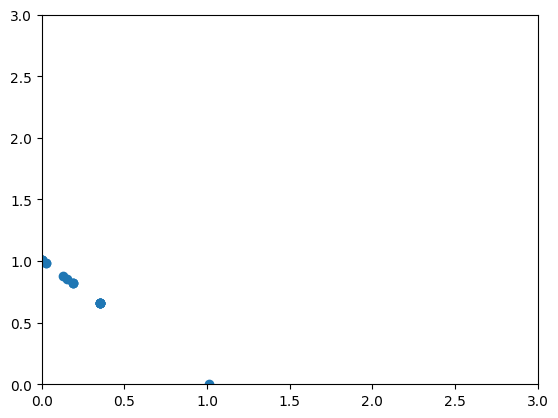

In [51]:
### Pominięcie miary CD
N = 20 # rozmiar populacji
GEN = 100 # liczba generacji/iteracji algorytmu
 
P = constructInitialPopulation(N) # utworzenie populacji początkowej
applyScoresAndSort(P, useCD = False) # posortowanie populacji wykorzystując fronty
# niezdominowane (bez miary cd; useCD = False)

for gen in range(GEN): # iteracja po kolejnych generacjach
    C = constructParents(N) # skonstruowanie identyfikatorów rodziców
    O = constructOffspring(P, C, gen + 1, 0.1) # konstrukcja potomstwa
    M = P + O # połączenie obecnej populacji z potomną
    applyScoresAndSort(M, useCD = False) # posortowanie tak połączonej populacji
    P = M[:N] # "przeżywają najlepiej przystosowani"
    if gen % (GEN / 4) == 0 or gen == GEN - 1: plotPopul(P) # co jakiś krok
        # ilustrowana jest populacja

# wypisanie statystyk
print(getStatsCD(P))

(0.20867308774217735, 0.6243137360007533, 0.13637104452781207, 0.11284242639298764)


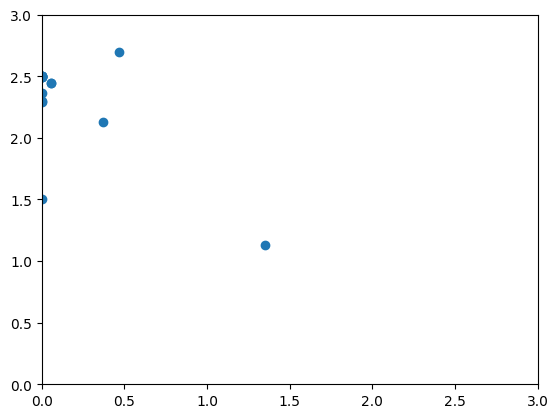

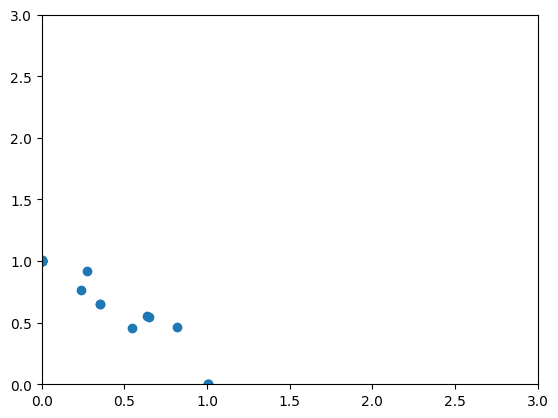

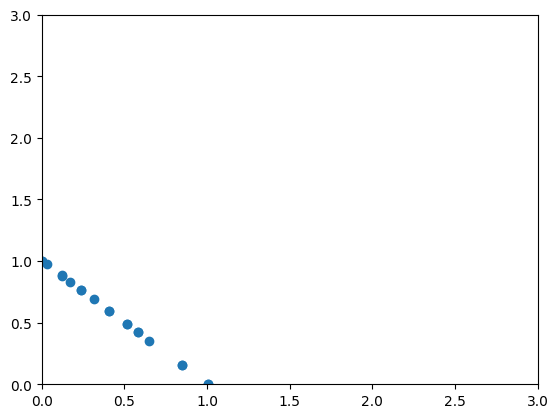

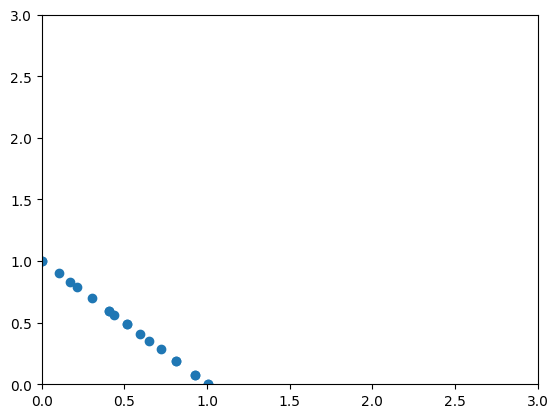

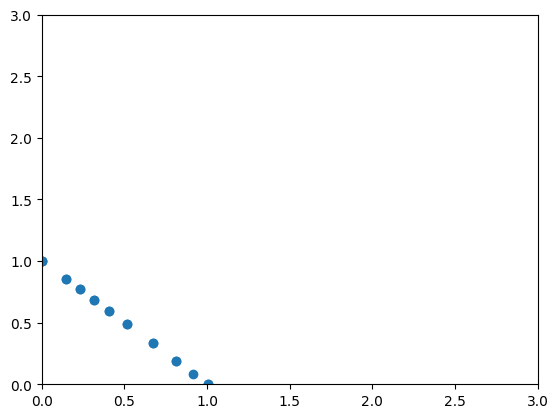

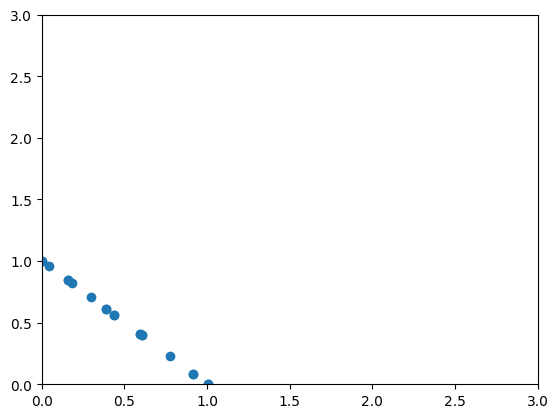

In [52]:
N = 20
GEN = 100

P = constructInitialPopulation(N)
applyScoresAndSort(P, useCD = True)

for gen in range(GEN):
    C = constructParents(N)
    O = constructOffspring(P, C, gen + 1, 0.1)
    M = P + O
    applyScoresAndSort(M, useCD = True)
    P = M[:N]
    if gen % (GEN / 5) == 0 or gen == GEN - 1: plotPopul(P)

print(getStatsCD(P))